<a href="https://colab.research.google.com/github/CodingTomo/TE-UrbanSound8K/blob/master/TE_UrbanSound8K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Progetto per TE

In [1]:
! pip install torchaudio

     |████████████████████████████████| 3.2MB 9.7MB/s 


In [2]:
import pandas as pd
import numpy as np
import torch
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

### Dataset

Il dataset UrbanSound8K contiene 8732 file audio della durata massima di 4 secondi contenenti il suono di una delle seguenti classi: *air_conditioner*, *car_horn*, *children_playing*, *dog_bark*, *drilling*, *enginge_idling*, *gun_shot*, *jackhammer*, *siren*, and *street_music*.

I file audio sono in formato *.wav* e essendo estratti da fonti differenti possono avere campionamento, profondità di bit e numero di canali diversi. I file audio completi possono essere trovati su [FreeSound](https://freesound.org).

I dataset è accompagnato da un *.csv* contenente il metadato associato ai file audio.

*   **slice_file_name**: è un nome composto che specifica la provenienza del singolo estratto rispetto alla traccia completa che può essere trovata su FreeSound.
*   **fsID**: FreeSound official ID.
*   **start**: Tempo di inizio dell'estratto in secondi rispetto alla traccia audio originale FreeSound.
*   **end**: Tempo di chiusura dell'estratto in secondi rispetto alla traccia audio originale FreeSound.
*   **salience**: indica la rilevanza (soggettiva) del suono all'interno dell'estratto. Vale 1 se è in primo piano, 2 se è un audio di fondo.
*   **fold**: In quale delle 10 cartelle in cui è organizzato il dataset si trova la traccia.
*   **classID**: etichetta.
*   **class**: descrizione dell'etichetta.




In [3]:
audio_metadata = pd.read_csv("/content/drive/Shared drives/TE-UrbanSound/UrbanSound8K/metadata/UrbanSound8K.csv")
audio_metadata['slice_length'] = audio_metadata['end'] - audio_metadata['start']

In [4]:
audio_metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class,slice_length
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,4.000000
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,4.000000
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,4.000000
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,4.000000
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,2.532098


Per esempio consideriamo la traccia `100652-3-0-3.wav` della cartella `fold2`. 

In [5]:
path_example = "/content/drive/Shared drives/TE-UrbanSound/UrbanSound8K/audio/fold2/100652-3-0-3.wav"
ipd.Audio(path_example)

Con l'aiuto di **torchaudio** siamo in grado di recuperare il dato e il metadato tecnico della traccia.


*   La funzione `load` legge il file *.wav* e restituisce una tupla contente il vettore che rappresenta la traccia e la frequenza di campionamento.
*   La funzione `torchaudio.info` restituisce alcuni dati tecnici fra cui profondità in bit e numero di canali.




In [6]:
example = torchaudio.load(path_example)
print('Il vettore rappresentante la traccia è:\n {}'.format(example[0].numpy()))
print("-"*40) 
print('La frequenza di campionamento è: {}Hz'.format(example[1]))
print("-"*40) 
print('Il metadato tecnico è: \n {}'.format(torchaudio.info(path_example)[0]))

Il vettore rappresentante la traccia è:
 [[-0.00411987 -0.00421143 -0.00341797 ...  0.00772095  0.00653076
   0.00549316]
 [-0.00106812 -0.00112915 -0.00064087 ...  0.01947021  0.01858521
   0.01687622]]
----------------------------------------
La frequenza di campionamento è: 44100Hz
----------------------------------------
Il metadato tecnico è: 
 sox_signalinfo_t {
  rate-> 44100
  channels-> 2
  precision-> 16
  length-> 352800
  mult-> 0
}



Il nostro esempio ha una durata di $4s$ ed è campionato a $44100$Hz su $2$ canali. La lunghezza del metadato dunque è il prodotto del numero di campioni per la durata della traccia per il numero di canali. Ci aspettiamo quindi che il tensore sia una matrice $2 \times 176400$. Verifichiamolo.

In [7]:
example[0].shape

torch.Size([2, 176400])

Possiamo anche visualizzare la traccia audio campionata nel tempo. 

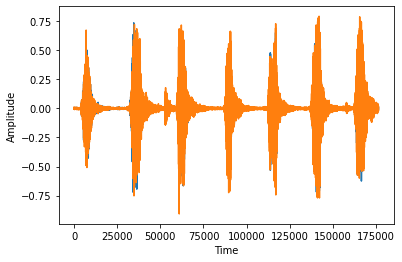

In [27]:
plt.figure()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(torch.squeeze(example[0]).t().numpy())

### Basic preprocessing

In una generica pipeline di preprocessing di dato acustico si  lavora con un solo canale. Ne nostro caso la traccia è stereo e la trasformazione in mono consiste nel sostituire il vettore della traccia con la media dei suoi canali.

In [9]:
waveform_mono = torch.mean(example[0], dim=0, keepdim=True)
print('Passando da stereo a mono il vettore rappresentante la traccia ha dimensione: {}'.format(waveform_mono.shape))

Passando da stereo a mono il vettore rappresentante la traccia ha dimensione: torch.Size([1, 176400])


Per semplificare la complessità del dato e di conseguenza del modello ricampioniamo il segnale a $8000$Hz.

In [10]:
sample_rate = 8000
waveform_mono_8K = torchaudio.transforms.Resample(new_freq=sample_rate, orig_freq=example[1])(waveform_mono)
waveform_8K = torchaudio.transforms.Resample(new_freq=sample_rate, orig_freq=example[1])(example[0])
print("La dimensione del segnale stereo ricampionato è {}, mentre del segnale in mono è {}".format(waveform_8K.shape, waveform_mono_8K.shape))

La dimensione del segnale stereo ricampionato è torch.Size([2, 32000]), mentre del segnale in mono è torch.Size([1, 32000])


Da ora in avanti lavoreremo con la traccia mono ricampionata a $8000$Hz

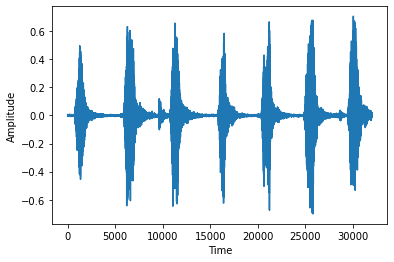

In [28]:
plt.figure()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(torch.squeeze(waveform_mono_8K).t().numpy())

### Fourier Transform
Nonostante le semplificazioni apportate alla traccia audio originale, il dato il nostro possesso risulta ancora difficilmente spendibile da un algoritmo di machine leaning. Per questa e altre ragioni legate alla fisionomia nel nostro udito conviene passare tramite la trasformata di Fourier ad una rappresentazione in frequenza. Moralmente siamo interessati a sostituire il tempo sull'asse $x$ con la frequenza e l'ampiezza sull'asse $y$ con l'energia trasportata dall'onda (per una determinata frequenza).

In [23]:
fft_8k_mono = np.fft.fft(torch.squeeze(waveform_mono_8K).t().numpy())

L'output della Fast Fourier Trasform è un vettore di dimensione uguale a quello di input che contiene numeri complessi. Per ragioni che non approfondiamo siamo interessati al modulo di questi numeri complessi. 

In [24]:
magnitude_8k_mono = np.abs(fft_8k_mono)

Generiamo la sequenza di punti che andrà a posizionarsi sull'asse $x$ rappresentante le frequenze.

In [25]:
frequency = np.linspace(0, sample_rate, len(magnitude_8k_mono))

Visualizziamo lo spettro in frequenza.

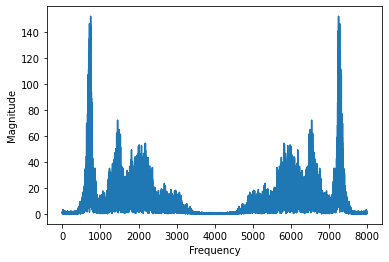

In [26]:
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.plot(frequency, magnitude_8k_mono)

Osserviamo che lo spettro in frequenza è simmetrico rispetto alla frequenza centrale. Questa è una proprietà generale della trasformata di Fourier.

### Short Fourier Trasform
Lo spettro calcolato nella sezione precedente ci dice l'ammontare dell'energia portata dall'onda sonora per singola frequenza. In rappresentazione però si perde totalmente l'informazione temporale.

Per esempio, potremmo osservare che una grande quantità di energia dell'onda sonora è portata dalle frequenze nell'intervallo da $7500Hz$ a $8000Hz$, ma non sapremmo dire se questa energia è localizzata nel tempo o è uniformente distribuita nei $4s$ di audio.

L'esigenza di non perdere l'infomazione temporale e al tempo stesso di non voler analizzare la traccia audio nella sua interezza porta a voler applicare la trasformata di Fourier in un modo diverso. L'idea è spezzare la traccia in piccoli frammenti consecutivi e parzialmente sovrapposti e operare su ognuno di questi la trasformata. I frammenti, generalmente lunghi $??ms$, sono abbastanza brevi da considerare approssimativamente costante l'audio al loro interno.  

In [38]:
n_fft = 512
hop_length = 128
sfft_8k_mono = torch.stft(torch.squeeze(waveform_mono_8K), n_fft=n_fft, hop_length=hop_length, onesided=False)

In [74]:
sfft_8k_mono.shape

torch.Size([512, 251, 2])

In [105]:
def magnitude(t):
  magnitude = t[:,0,0]**2+t[:,0,1]**2
  for i in range(t.shape[1]):
    np.hstack((magnitude, t[:,i,0]**2+t[:,i,1]**2))
    
  return magnitude

magnitude = magnitude(sfft_8k_mono.numpy())
magnitude

array([4.19533986e-04, 2.11908944e-08, 4.22382494e-04, 4.19509422e-04,
       1.85225438e-02, 1.88575208e-03, 3.59975442e-04, 2.19528330e-03,
       6.28313574e-04, 2.44680723e-06, 2.66585173e-03, 3.46306588e-05,
       2.99946646e-06, 1.01155872e-02, 1.74976333e-06, 1.39898877e-03,
       2.65600276e-03, 8.93579971e-04, 3.89374816e-03, 7.19060609e-03,
       9.99928685e-04, 1.53275684e-03, 5.90195377e-05, 3.01974965e-03,
       6.46162925e-06, 1.32595259e-03, 2.00199941e-03, 2.71343924e-05,
       1.60600117e-03, 4.73396620e-03, 1.52368238e-03, 2.22591800e-03,
       3.94325843e-03, 1.99787202e-04, 1.28791938e-02, 1.83301992e-04,
       1.40913045e-02, 5.55296615e-03, 1.99733971e-04, 1.09316865e-02,
       1.30297150e-03, 3.39426845e-03, 2.07400313e-04, 3.06509482e-03,
       1.72318437e-07, 8.82600807e-03, 2.26247590e-02, 1.01979040e-02,
       5.52131096e-04, 9.02675820e-05, 1.49829127e-02, 2.48830693e-05,
       7.44777435e-06, 7.88766250e-04, 2.52098450e-03, 2.60194036e-04,
      

### Spettrogrammi 

Shape of spectrogram: torch.Size([1, 201, 883])


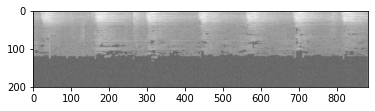

In [18]:
specgram = torchaudio.transforms.Spectrogram()(waveform_mono)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([1, 201, 161])


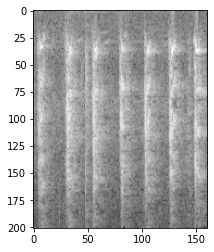

In [19]:
specgram = torchaudio.transforms.Spectrogram()(waveform_mono_8K)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')